## Tesis results

In [1]:
import src.utils as utils
from src.solvers import pg_solver
from ray import tune

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import os

from tbparse import SummaryReader
import seaborn as sns; sns.set_theme()

2023-07-12 22:53:29.380741: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


### Why it is important to load dataframe instead of get_best_results

In [2]:
# Load best results
exp_path = 'hypersearch/pg_solver/0030/0135/rand_n=0030_k=03_m=0135_i=01/arch'

# Restore the GridSearch object
restored_tuner = tune.Tuner.restore(path=exp_path,
                                    trainable=pg_solver,
                                    resume_unfinished=False,
                                    resume_errored=False,
                                    restart_errored=False)

results = restored_tuner.get_results()

# Check if there have been errors
if results.errors:
    print("Errors reported.")
else:
    print("No errors reported.")

# Get best trial
print(results.get_best_result(metric='num_sat_eval', mode='max', scope='last').metrics['num_sat_eval'])
print(results.get_best_result(metric='num_sat_eval', mode='max', scope='all').metrics['num_sat_eval'])
print(results.get_dataframe(filter_metric='num_sat_eval', filter_mode='max')['num_sat_eval'].max())

The trainable will be overwritten - this should be done with caution: it's possible to supply an incompatible trainable, and there are no guarantees that the resumed experiment will continue successfully. If you encounter errors during training, ensure that you are passing in the same trainable that was passed into the initial `Tuner` object.


No errors reported.
129.0
125.0
130.0


### WalkSAT

<Figure size 640x480 with 0 Axes>

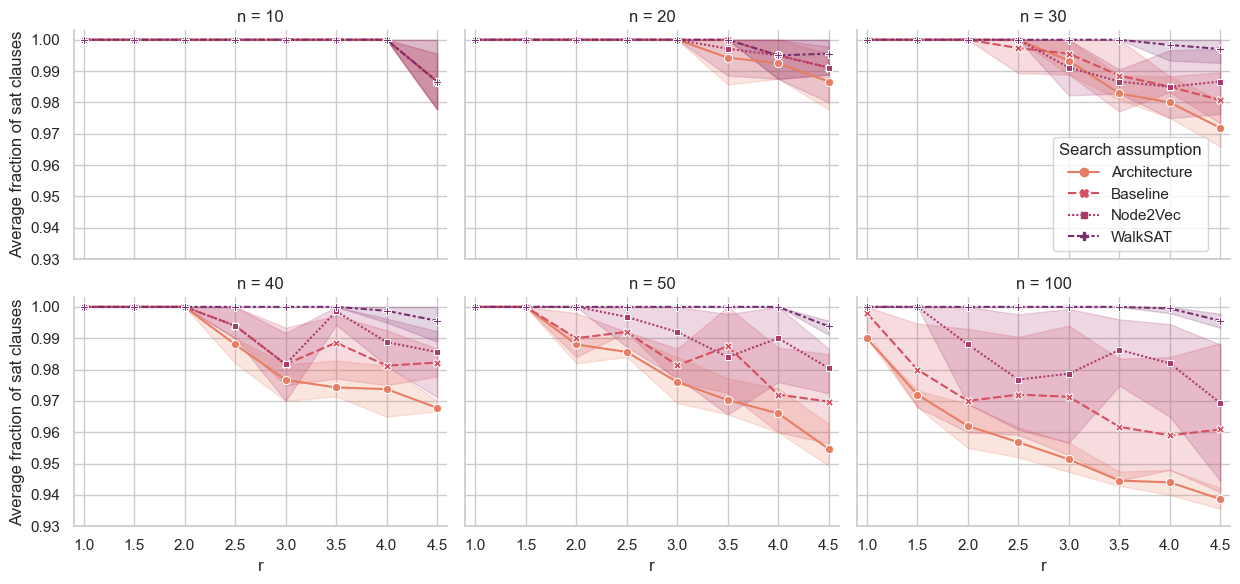

In [2]:
from walksat.walksat_emreyolcu import WalkSATme
import src.utils as utils
import pandas as pd
import os

data_folder = 'data/rand'
csv_path = 'results/df_best_trials.csv'
num_tries = [25]
num_flips = 750#10000
p = 0.5

# Get the path for every instance in the data folder    
paths = []
for root, dirs, files in os.walk(data_folder):
    for filename in files:
        paths.append(os.path.join(root, filename))
paths = sorted(paths)

# Build WalkSAT dataframe
dic_walksat = {}
# Extract info from search_path
for i, instance_dir in enumerate(paths):
    # Create experiment id
    split_path = instance_dir.split("/")
    n_ = split_path[2]
    m_ = split_path[3]
    i = split_path[4][-6:-4]
    s = 'WalkSAT'
    exp_id = f'{n_}/{m_}/{i}/{s}'

    # Load formula
    n, m, formula = utils.dimacs2list(instance_dir)
    assert (int(n_) == n) and (int(m_) == m), f"n and m do not match in {instance_dir}"
    r = float(m) / float(n)
    
    # Run WalkSAT
    for n_tries in num_tries:
        walksat = WalkSATme(max_tries=n_tries, max_flips=num_flips, p=p)
        total_solved = walksat.run(formula, n, m)
        unsats_per_trial = walksat.unsat_clauses

        num_sat_list = []
        for j, trial in enumerate(unsats_per_trial):
            unsat = trial[-1]
            num_sat = m - unsat
            #print(f'{j}: {m} - {unsat} = {num_sat}')
            num_sat_list.append(num_sat)
        #num_sat_list = [(m - trial[-1]) for trial in unsats_per_trial]
        max_num_sat = max(num_sat_list)
        frac_sat = max_num_sat / float(m)
        dic_walksat[exp_id] = [exp_id, n, r, int(i), s, frac_sat]

columns = ['exp', 'n', 'r', 'i', 's', 'frac_sat']
df_best_walksat = pd.DataFrame.from_dict(dic_walksat, orient='index', columns=columns)

# Keep only rows with n=10, 20, 30, 40, 50, 100
df_best_walksat = df_best_walksat[df_best_walksat['n'].isin([10, 20, 30, 40, 50, 100])]


# Build df_best_trials
# Load df_best_trials from csv
df_best_trials = pd.read_csv(csv_path)
# Keep only exp, n, r, i, s, frac_sat
df_max_frac_sat = df_best_trials[['exp', 'n', 'r', 'i', 's', 'frac_sat']]
# Drop duplicates, keeping the fraction of satisfiable clauses with the highest value for each experiment
df_max_frac_sat = df_max_frac_sat.drop_duplicates(subset=['exp'])


# Concat df_max_frac_sat and df_best_walksat
df_max_frac_sat = pd.concat([df_max_frac_sat, df_best_walksat], ignore_index=True)


# Generate figure
plt.figure()
sns.set_theme(style="whitegrid")
g = sns.relplot(data=df_max_frac_sat, x="r", y="frac_sat", hue="s", style="s", col="n", col_wrap=3,
                errorbar=('ci', 99), markers=True, palette='flare', kind='line',
                facet_kws=dict(sharex=True, sharey=True), height=3, aspect=1.4, legend='auto')

g.axes[0].set_ylim(0.93, 1.003)
g.axes[1].set_ylim(0.93, 1.003)
g.axes[2].set_ylim(0.93, 1.003)
g.axes[3].set_ylim(0.93, 1.003)
g.axes[4].set_ylim(0.93, 1.003)
g.axes[5].set_ylim(0.93, 1.003)

g.axes[0].set_yticks([0.93, 0.94, 0.95, 0.96, 0.97, 0.98, 0.99, 1.00])
g.axes[1].set_yticks([0.93, 0.94, 0.95, 0.96, 0.97, 0.98, 0.99, 1.00])
g.axes[2].set_yticks([0.93, 0.94, 0.95, 0.96, 0.97, 0.98, 0.99, 1.00])
g.axes[3].set_yticks([0.93, 0.94, 0.95, 0.96, 0.97, 0.98, 0.99, 1.00])
g.axes[4].set_yticks([0.93, 0.94, 0.95, 0.96, 0.97, 0.98, 0.99, 1.00])
g.axes[5].set_yticks([0.93, 0.94, 0.95, 0.96, 0.97, 0.98, 0.99, 1.00])
# g.axes[0].set_yticklabels([])  # Remove y tick labels

g.axes[0].set_xlim(0.9, 4.6)
g.axes[1].set_xlim(0.9, 4.6)
g.axes[2].set_xlim(0.9, 4.6)
g.axes[3].set_xlim(0.9, 4.6)
g.axes[4].set_xlim(0.9, 4.6)
g.axes[5].set_xlim(0.9, 4.6)

g.axes[0].set_xticks([1.0, 1.5, 2.0, 2.5, 3.0, 3.5, 4.0, 4.5])
g.axes[1].set_xticks([1.0, 1.5, 2.0, 2.5, 3.0, 3.5, 4.0, 4.5])
g.axes[2].set_xticks([1.0, 1.5, 2.0, 2.5, 3.0, 3.5, 4.0, 4.5])
g.axes[3].set_xticks([1.0, 1.5, 2.0, 2.5, 3.0, 3.5, 4.0, 4.5])
g.axes[4].set_xticks([1.0, 1.5, 2.0, 2.5, 3.0, 3.5, 4.0, 4.5])
g.axes[5].set_xticks([1.0, 1.5, 2.0, 2.5, 3.0, 3.5, 4.0, 4.5])

g.axes[0].set_ylabel('Average fraction of sat clauses')
g.axes[1].set_ylabel('')
g.axes[2].set_ylabel('')
g.axes[3].set_ylabel('Average fraction of sat clauses')
g.axes[4].set_ylabel('')
g.axes[5].set_ylabel('')

# Configure legend
leg = g._legend
leg.set_bbox_to_anchor([0.88, 0.65])
new_labels = ['Architecture', 'Baseline', 'Node2Vec']
for t, l in zip(leg.texts, new_labels): t.set_text(l)
leg.set_title('Search assumption')
leg.set_frame_on(True)

#plt.tight_layout()
#plt.subplots_adjust(wspace=0.0, hspace=0.1)
#plt.show()
plot_path = 'results/walksat.png'
plt.savefig(plot_path, dpi=300, bbox_inches='tight', pad_inches=0.1)